# Submission Exercises after Lecture 3
This notebook contains the submission exercises with the instructions and explanations.

Work through the cells below in a sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you will also find questions. Try to reflect on the questions before/after running the code.

You have 3 exercises to complete. In total, you can get 15 points [5 points per each exercise] out of 60 points for Submission 1 for completing all marked exercises related to lecture 3.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).

Some pieces of code were adopted from the notebooks developed at the  [Idiap Research Institute](https://www.idiap.ch) by [Olivier Canévet](mailto:olivier.canevet@idiap.ch).

In [1]:
import getpass
import os
import random
import re
import tarfile
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd

##### **Following pieces of code are taken from the Practice_3.ipynb notebook. Here the solutions for the exercises are provided**
We are going to load a dataset composed of images of the following fruits: apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

The dataset has the following structure:

```text
fruits/
|-- train/
|   |-- apple/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|
|-- val/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
```

which can be loaded as is with the ImageFolder class of PyTorch.
Check out the documentation for more details: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

The dataset in NOTO is located in /usr/local/share/.cache/deep_learning unless you work on your local computer, in which case the data set should be located in ./data.

We provide a link to download the dataset, but there might be a limit on a number of people who can use the link. We encourage you to use NOTO and shared data directory for this assignmnet.

In [2]:
# Location where data will be downloaded. To avoid duplicate of data
# for the teacher (submission, feedback, autograded, ...). On local
# machine, the data is located in the same folder as the notebook in
# "./data"
mirrors = (
    "/usr/local/share/.cache/deep_learning", # EPFL NOTO
)
for mirror in mirrors:
    DATADIR = Path(mirror) / "data"
    if DATADIR.is_dir():
        break
else:
    DATADIR = "data"
print(f"Using data directory '{DATADIR}'")

# For efficient usage of the hardware resources when running on JupyterHub EPFL,
# we will limit the number of threads. If you are running this code on your local
# machine or on colab, the following code will not do anything.
if getpass.getuser() == "jovyan":
    num_threads_limit = 4
elif re.search('^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Using data directory 'data'
Limiting the number of threads to 12
PyTorch is using 12 threads


<>:21: SyntaxWarning: invalid escape sequence '\.'
<>:21: SyntaxWarning: invalid escape sequence '\.'
/var/folders/cz/htq4mhw10zn44m6frvcd43pr0000gn/T/ipykernel_58960/2022555167.py:21: SyntaxWarning: invalid escape sequence '\.'
  elif re.search('^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:


In [3]:
url = "https://www.idiap.ch/~ocanevet/master-ai/fruits.tgz"
DATA_TAR_FILE = Path(DATADIR) / "fruits.tgz"
if not Path(DATA_TAR_FILE).is_file():
    print(f"Downloading data set to {DATA_TAR_FILE}")
    datasets.utils.download_and_extract_archive(url, download_root=DATADIR)
else:
    print(f"Data set already in {DATA_TAR_FILE}")

Data set already in data/fruits.tgz


If you have not changed anything on the default paths, the following code will load the dataset:
- the training images are in the folder ```<DATADIR>/fruits/train```
- the validation images are in the folder ```<DATADIR>/fruits/valid```

In [4]:
#path to the train and val folders
train_dir = Path(DATADIR) / "fruits" / "train"
valid_dir = Path(DATADIR) / "fruits" / "val"

#name of the classes
classes = ("apple", "banana", "bean", "carrot", "grape", "onion", "pear", "potato", "strawberry", "tomato")
NUM_CLASSES = len(classes) #apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

# batch size
batch_size = 10


In Pytorch, when you load a dataset, you can pass a set of transformations to perform on the images before feeding them to a network. Usually, the transformations consist of: resizing and cropping the image, rotating the image, cast to a tensor, normalizing the image, etc.

Here you can find the available transformations in Pytorch: https://pytorch.org/vision/stable/transforms.html

In [5]:
# Adaptation of the code from Lab2
# mean and std for normalisation are chosen based on ImageNet statistics
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(valid_dir, transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)


batch size:  10


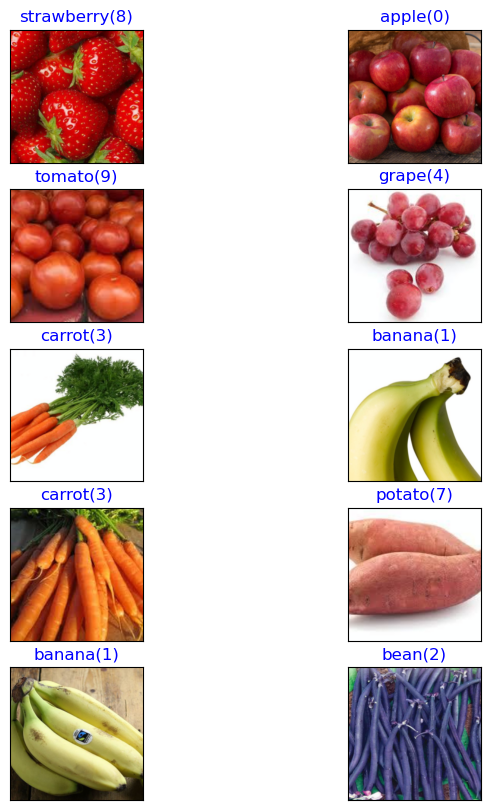

In [6]:
# Visualization of images

# get some random training images
# a quick explanation of iter() and next():
# https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader


def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    print("batch size: ", batch_size)
    fig = plt.figure(figsize=(8, 10))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

how many images in the train set:  400


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


images per class in dataloader:  {'grape': 40, 'banana': 40, 'apple': 40, 'bean': 40, 'tomato': 40, 'strawberry': 40, 'potato': 40, 'pear': 40, 'carrot': 40, 'onion': 40}


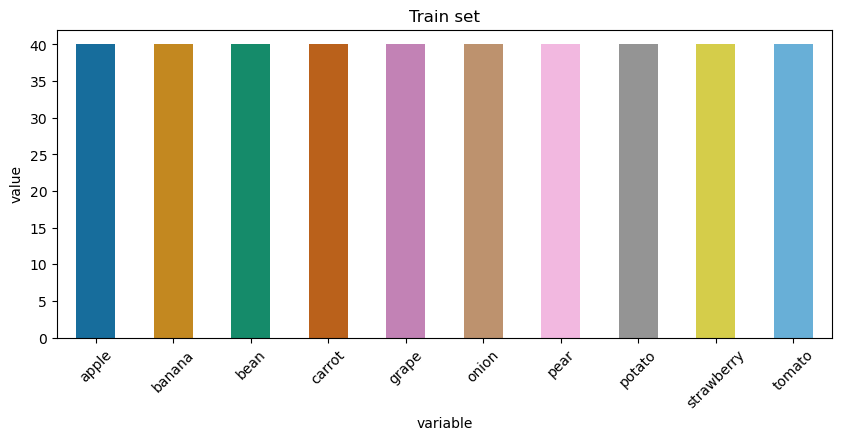

In [7]:
# class distribution
import seaborn as sns
from collections import Counter

print("how many images in the train set: ", len(train_set.targets))

# later in this exercise you will explore the ways to rebalance the data in the dataloader
# Recall from Lab2 how to visualise the distributions of the images in the dataloader
def plot_class_distribution_for_dataloader(dataloader):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for _, target in dataloader:
        for t in target:
            t = classes[int(t)]
            if t not in count_dict:
                count_dict[t] = 0
            count_dict[t] += 1
    print("images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class ditribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title("Train set")
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.show()

plot_class_distribution_for_dataloader(train_loader)
## the training set is perfectly balanced: same number of image for all classes

###### Metrics
Introducing simple metrics, such as accuracy and F1-score.

In [8]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

###### Model

In [9]:
import torchvision.models as models

In [10]:
class FruitNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        # Loading AlexNet
        self.model = models.alexnet(weights=weights)
        # Changing the last layers
        # to reduce the computational complexity we reduce the size of hidden layers
        self.model.classifier[1] = nn.Linear(9216, 64)
        self.model.classifier[4] = nn.Linear(64, 32)
        self.model.classifier[6] = nn.Linear(32, 10)

    def freeze_feature_layers(self):
        # Freeze the feature extraction part
        for param in self.model.features:
            param.requires_grad_(False)

    def forward(self, x):
        return self.model(x)

###### Implementing the training and evaluation functions, logging and plotting the metrics.

In [11]:
##
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output



def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    model.train()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        #clean previously computed gradients
        optimizer.zero_grad()

        # forward
        outputs = model(data)

        #compute predictions
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)

        #compute loss
        loss = criterion(outputs, target)

        #do backward and oprimizer steps
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [12]:
def evaluate(model, criterion, metrics, test_loader, device):
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # we don't compute gradients here
            data = x_batch.to(device)
            target = y_batch.to(device)

            #forward
            outputs = model(data)

            #compute loss
            loss = criterion(outputs, target)

            #compute predictions
            _, preds = torch.max(outputs, 1)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)

            # log loss statistics
            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [13]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [14]:
#actually you have to use validation for each step of training, but now we will focus only on the toy example and will track the perfromance on test
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


##### 1.3.1 Data augmentation on the balanced dataset. Application of various augmentation techniques to the dataset to improve performance. The task includes finding a suitable combination of various data transformations.

First, you have to train a neural network on the Fruits dataset without any augmentation. (taken from exercises)

train Loss: 0.5955,  ACC: 0.7925, F1-weighted: 0.7113
eval Loss: 0.4921,  ACC: 0.8600, F1-weighted: 0.5119


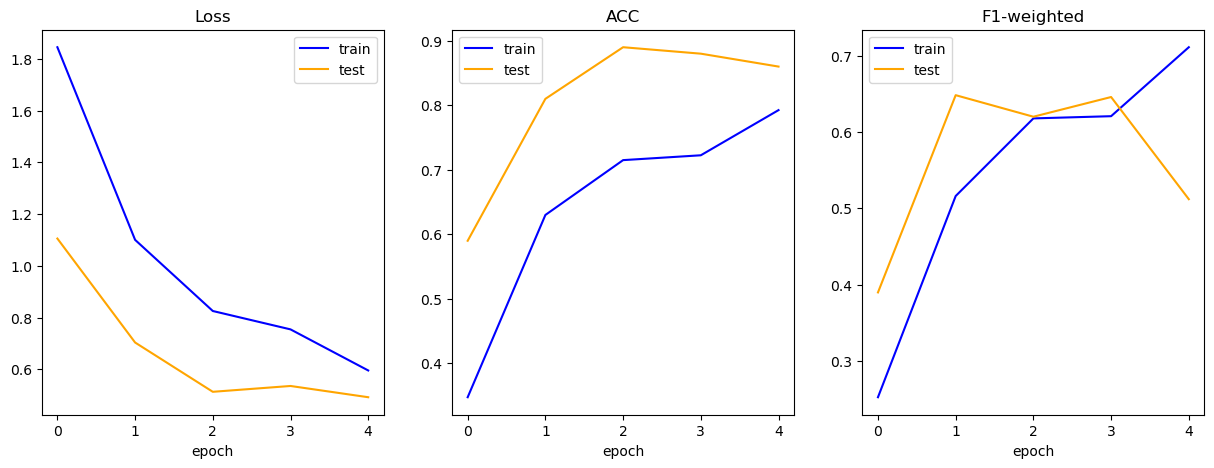

In [15]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")

criterion.to(device)
model.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')

 You should get test accuracy >= 83%. The model can start to overfit, especially that is noticeable on f1-score

**TODO** Augment the training dataset. Add 3 torchvision transformations to make dataset more diverse and retrain the network to achieve 1 percent point(p.p.) improvement of performance in accuracy and around 3p.p. improvement in f1 score over the previous results. Adding augmentations should allow the new model to overfit much less.

batch size:  10


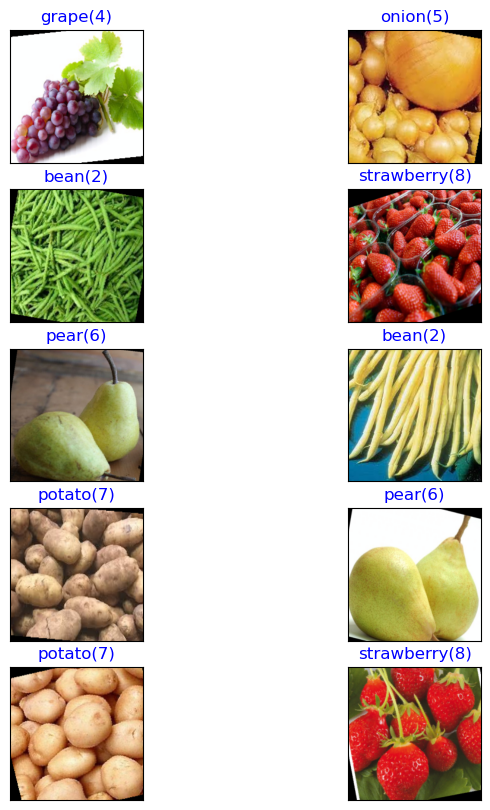

In [16]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)


# TODO add three transformations from torchvision transforms different from ones that are already listed below like Resize or CenterCrop
transform_train = transforms.Compose([

    # YOUR CODE HERE
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1), ratio=(0.8, 1.25)),
    #transforms.ColorJitter(brightness=0.05, contrast=0.5, saturation=0.5, hue=0.05),
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])



augmented_train_set = datasets.ImageFolder(train_dir, transform_train)
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_set, batch_size=batch_size, shuffle=True)

# plot augmented images
dataiter = iter(augmented_train_loader)
images, labels = next(dataiter)

plot_images_from_dataset(images, labels)


# Validation set stays as it is
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])
valid_set = datasets.ImageFolder(valid_dir, transform)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

train Loss: 0.5113,  ACC: 0.8150, F1-weighted: 0.7484
eval Loss: 0.4082,  ACC: 0.9100, F1-weighted: 0.6614


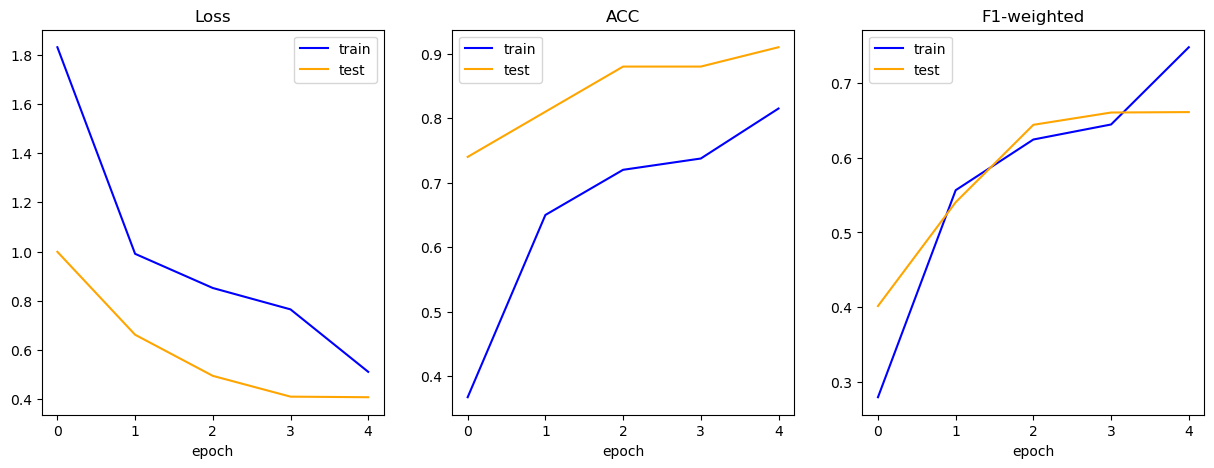

In [17]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train two more apochs in comparison to previous training
N_EPOCHS = 5
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, augmented_train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

You should achive improvement in the performance. We suppose that the model accuracy should be higher than 0.85. Although, training process contains randomness and you might get slightly different performance. Don't worry if your assert doesn't pass and your accuracy is slightly lower, this task will be marked manually

In [18]:
assert test_metrics_log[0][-1] >= 0.85

##### 1.3.2 Construct and use a weighted sampler on the imbalanced dataset. Compare the performance of models trained with and without a sampler. Analyse how accuracy and F1 score differently react to the changes in the predictions.

Now imagine that your training data was collected in a year, when the harvest of tomato, potato and strawberry was very bad. As a result, you were able to take fewer photos of those fruits and vegetables and now have less training data for those classes. While you still want the network to work equally good for all the classes and to test that you have to keep the validation dataset balanced.

We imitate the lower amount of photoes of potatoes, strawbery and tomato in the train dataset by dropping 20%, 50% and 70% of images of those classes, chosen randomly for mentioned fruits(and veg) correspondingly.


First, train the model on imbalanced dataset. Reflect on the changes in accuracy and f1 score in comparison to the model trained on full dataset.


In [19]:
# we selected for you which files will be excluded from the training set

classes_dropped_images_path = {}
classes_dropped_images_path['potato'] = ['038.jpg', '008.jpg', '034.jpg', '018.jpg', '029.jpg', '002.jpg', '006.jpg', '036.jpg']
classes_dropped_images_path['strawberry'] = ['039.jpg', '035.jpg', '019.jpg', '008.jpg', '002.jpg', '031.jpg',
       '006.jpg', '007.jpg', '024.jpg', '012.jpg', '020.jpg', '000.jpg',
       '023.jpg', '009.jpg', '018.jpg', '014.jpg', '016.jpg', '029.jpg',
       '030.jpg', '010.jpg']
classes_dropped_images_path['tomato'] = ['007.jpg', '009.jpg', '034.jpg', '027.jpg', '014.jpg', '026.jpg',
       '010.jpg', '024.jpg', '003.jpg', '035.jpg', '033.jpg', '036.jpg',
       '002.jpg', '016.jpg', '023.jpg', '000.jpg', '039.jpg', '015.jpg',
       '038.jpg', '028.jpg', '022.jpg', '001.jpg', '011.jpg', '031.jpg',
       '020.jpg', '029.jpg', '017.jpg', '006.jpg']

for k in classes_dropped_images_path.keys():
    # get a path for dropped training samples
    classes_dropped_images_path[k] = [str(train_dir / k / x) for x in classes_dropped_images_path[k]]

def not_dropped_images(filepath):
    for k in classes_dropped_images_path:
        if filepath in classes_dropped_images_path[k]:
            return False
    return True

# we use transform train implemented in the previous task for more stable results.
# If you didn't do the previous task, replace transform_train with transform in the next line
train_imbalanced_set = datasets.ImageFolder(train_dir, transform_train, is_valid_file=not_dropped_images)
valid_set = datasets.ImageFolder(valid_dir, transform)
train_imbalanced_loader = torch.utils.data.DataLoader(train_imbalanced_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


images per class in dataloader:  {'strawberry': 20, 'carrot': 40, 'grape': 40, 'pear': 40, 'bean': 40, 'potato': 32, 'onion': 40, 'apple': 40, 'banana': 40, 'tomato': 12}


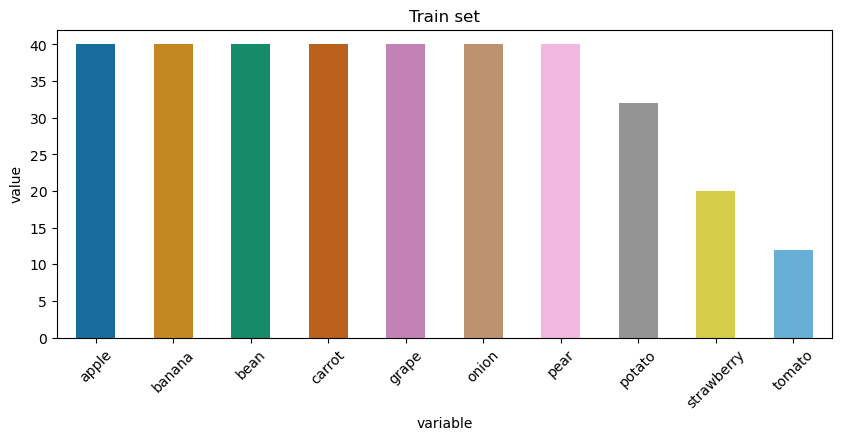

In [20]:
#let's look at distribution of classes in train loader
plot_class_distribution_for_dataloader(train_imbalanced_loader)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


images per class in dataloader:  {'apple': 10, 'banana': 10, 'bean': 10, 'carrot': 10, 'grape': 10, 'onion': 10, 'pear': 10, 'potato': 10, 'strawberry': 10, 'tomato': 10}


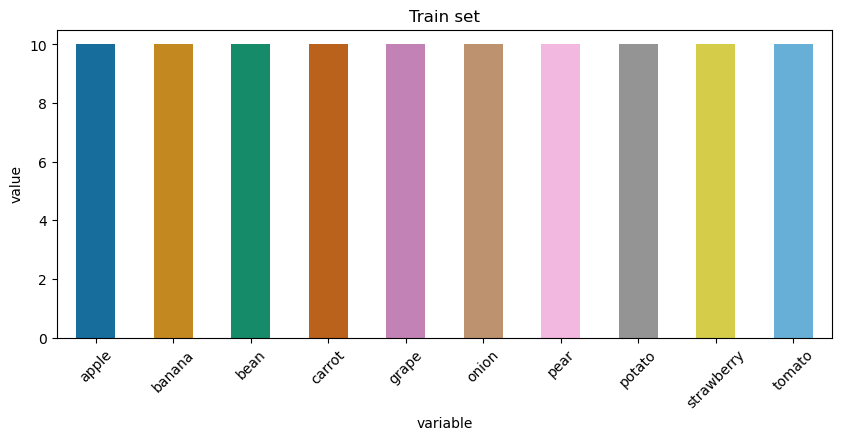

In [21]:
#and distribution of classes in valid loader
plot_class_distribution_for_dataloader(valid_loader)

train Loss: 0.7422,  ACC: 0.7300, F1-weighted: 0.6251
eval Loss: 0.5999,  ACC: 0.7800, F1-weighted: 0.5300


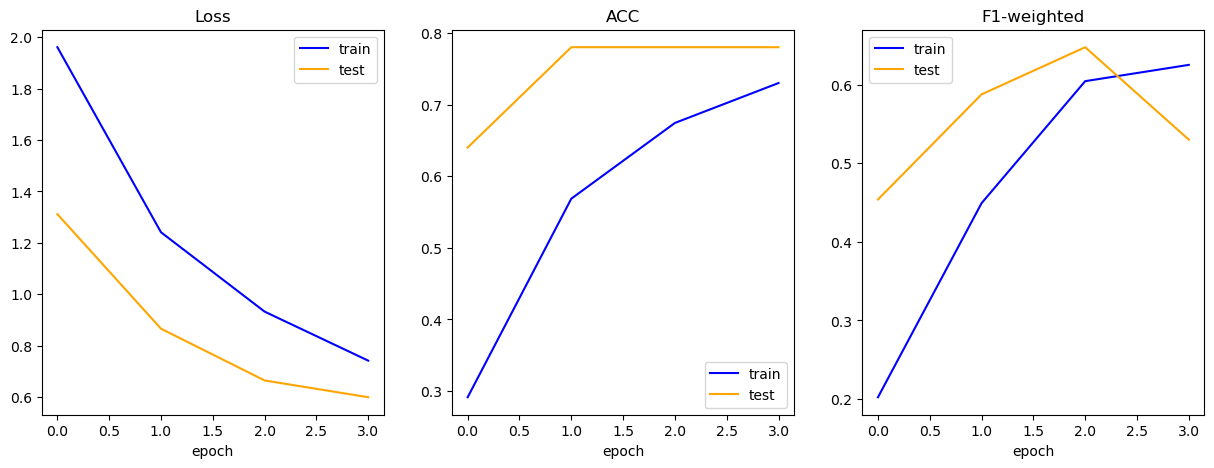

In [22]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001
weight_decay = 0.01

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

N_EPOCHS = 4
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_imbalanced_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_imbalanced_dataset.pth')

We expect achieved f1 score to be lower than 0.6

**TODO** write a custom batch data sampler, that resamples the dataset with respect to desired weights of the classes.

You are **not allowed** to use torch implementation of random sampler and have to create the class on your own. You are only allowed to inherit from a standart sampler torch.utils.data.Sampler.



In [23]:
from torch.utils.data import Sampler # inherit from PyTorch's Sampler class
class CustomDataSampler(Sampler):
    def __init__(self,
                 dataset,
                 sampling_weights,
                 ):
        '''
        sampling_weights: dictionary, where keys are image classes and values
        are weights of each class, not necessary summing up to one.

        dataset: imbalanced dataset
        '''

        super().__init__(dataset)
        self.dataset = datasets
        self.number_of_classes = len(sampling_weights)
        self.sampling_weights = sampling_weights
        # YOUR CODE HERE

        # Create a empty list of indices for each class
        self.indices = {i: [] for i in range(self.number_of_classes)}
        
        print("Number of classes: ", self.number_of_classes)
        print("Sampling weights: ", self.sampling_weights)
        print("Empty indices: ", self.indices)
        
        # For each image in the dataset, add its index to the list of indices for its class
        for idx, (img, label) in enumerate(dataset):
            self.indices[label].append(idx)

        print("Indices: ", self.indices)

        # Calculate the number of samples in the resampled dataset
        self.num_samples = sum([int(self.sampling_weights[i] * len(self.indices[i])) for i in range(self.number_of_classes)])

        print("Number of samples in the resampled dataset: ", self.num_samples)


    def __iter__(self):
        # you need to create a list of indices that will be used in dataloader
        # the output should be iter(list_of_indexes)
        # length of list_of_indexes should be equal to sum([class_weight * number_of_elements_in_this_class for each_of_the classes])
        # you can add some randomness in how many examples are drawn from each class

        # for example, your dataset for binary classification contains samples [[a, 0], [b, 0], [c, 0], [d, 0], [e, 1], [f, 1]],
        # where 1st element in the pair is input(letters) and the 2nd is target(0 or 1)
        # dataset[0] will return the first element of the dataset: [a, 0]
        # and sampling_weights are {0: 1, 1: 2}
        # The expected output of the sampler will be a list of indexes that should be drawn from the dataset.
        # The length of the outputted indexes list should be equal to 8
        # Although implementations of sampler and amount of randomness inside can vary.
        # You can decide for yourself how random your sampler will be
        # One possible list of outputted indexes with one implementation can be [0, 1, 2, 3, 4, 5, 4, 4],
        # In dataloader corresponding elements of outputted indexes will be drawn from the dataset one by one
        # Another possible output can be [0, 0, 2, 4, 5, 4, 4, 5],
        # Where we see that not all elements from the original dataset are going to be present in this epoch
        # and the weights of the classes in the outputted indexes are slightly different from sampling_weights.
        # This output includes more randomness, which is fine for bigger datasets.
        
        # YOUR CODE HERE

        # Create a list to hold the final order of indices
        final_indices = []

        # For each class, randomly choose indices based on the class's weight
        for class_idx, class_indices in self.indices.items():
            print("Class_indices: ", class_indices)
            num_samples_from_class = int(self.sampling_weights[class_idx] * len(class_indices)) # Number of samples to take from this class
            final_indices += list(np.random.choice(class_indices, num_samples_from_class)) # Add the randomly chosen indices to the final list
        # Shuffle the indices to prevent the model from learning potential patterns in the order of the samples, which could lead to overfitting
        np.random.shuffle(final_indices)

        print("Final indices: ", final_indices)

        return iter(final_indices)

    def __len__(self):
        # return len of the resampled dataset
        # YOUR CODE HERE
        return self.num_samples
        


In [24]:
# initialise desired sampling weights
sampling_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1 / 0.8, 8: 1 / 0.5, 9: 1 / 0.3}


Number of classes:  10
Sampling weights:  {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1.25, 8: 2.0, 9: 3.3333333333333335}
Empty indices:  {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}


/Users/theoh/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Indices:  {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 1: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 2: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], 3: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159], 4: [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], 5: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


images per class in dataloader:  {'apple': 40, 'pear': 40, 'bean': 40, 'banana': 40, 'strawberry': 40, 'onion': 40, 'tomato': 40, 'carrot': 40, 'potato': 40, 'grape': 40}


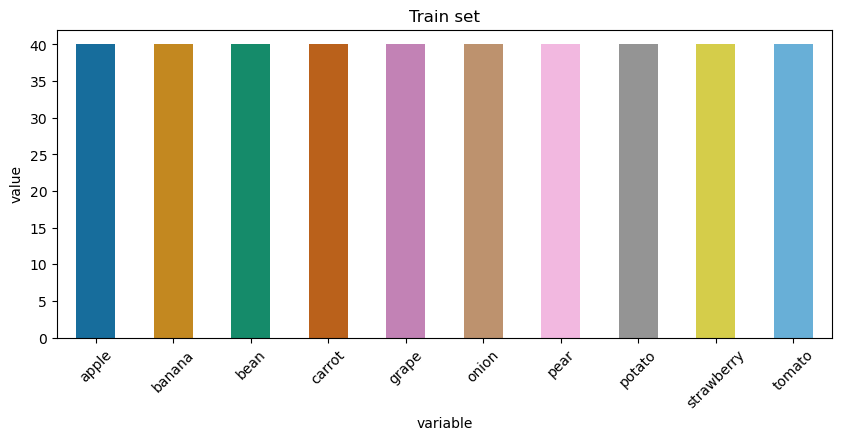

In [25]:
#initialize datasampler
train_sampler = CustomDataSampler(train_imbalanced_set, sampling_weights=sampling_weights)
train_imbalanced_resampled_loader = torch.utils.data.DataLoader(train_imbalanced_set, sampler=train_sampler, batch_size=batch_size)

# for validation we use balanced data
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

#let's look at distribution of classes in train loader
plot_class_distribution_for_dataloader(train_imbalanced_resampled_loader)
# each class should have 40 images

Class_indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Class_indices:  [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Class_indices:  [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
Class_indices:  [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
Class_indices:  [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Class_indices:  [200, 201

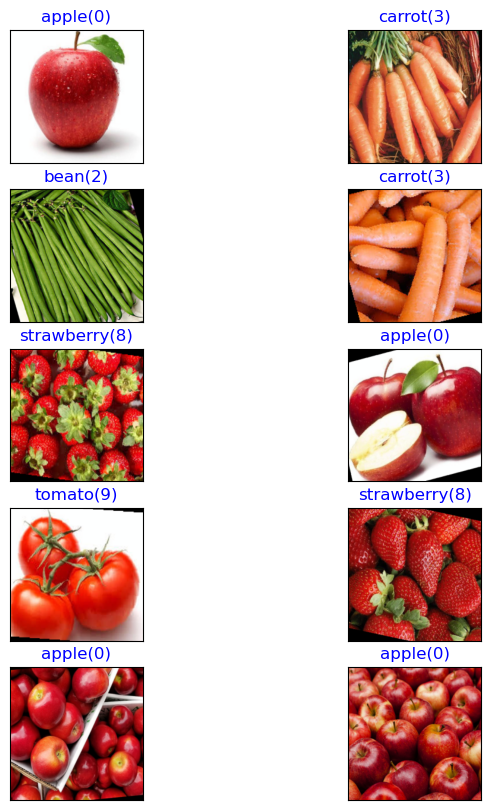

In [26]:
dataiter = iter(train_imbalanced_resampled_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

If you did everything correctly the train_imbalanced_resampled_loader should contain relatively similar number of images per each class around 40.


train Loss: 0.6500,  ACC: 0.7850, F1-weighted: 0.6942
eval Loss: 0.5292,  ACC: 0.8800, F1-weighted: 0.6942


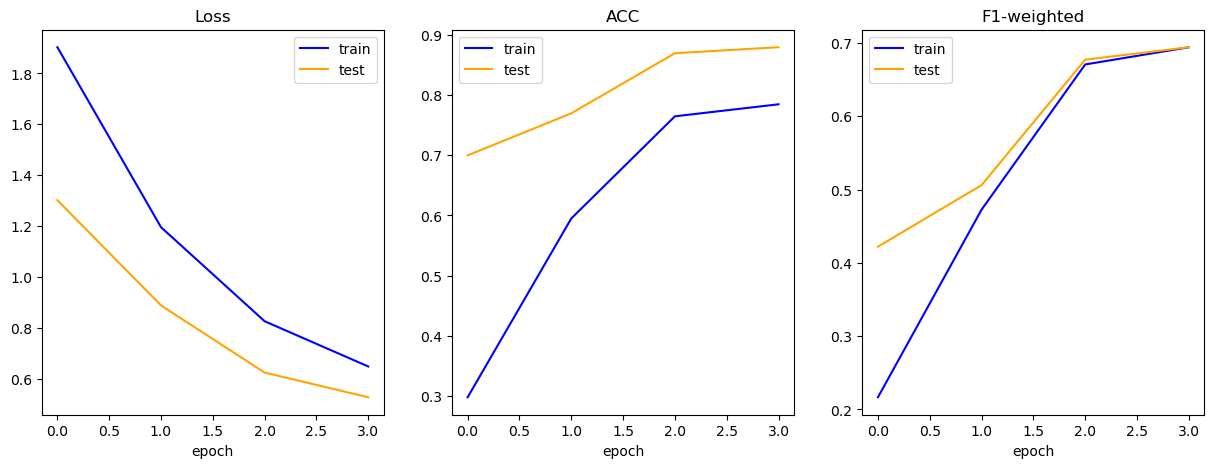

In [27]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0005
weight_decay = 0.08 #increased wight decay and smaller lr as we now have repetitions of datasamples and model can overfit easier

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

N_EPOCHS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_imbalanced_resampled_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_imbalanced_resampled_dataset.pth')

##### 1.3.3 Construct a weighted loss function to mitigate the imbalance of the dataset. Train the model with this function and analyse the results. The loss should reflect the frequency of appearance of each class, giving less weight to common classes to improve balance.

You have to implement a weighted loss for function, where for each class corresponds a certain weight, and a sequence of weights not necessary sums up to one. This is already implemented in pytroch torch.nn.CrossEntropyLoss() with parameter weight, but you are not allowed to set parameter weight to anything except for None.
You are only allowed to use torch.nn.CrossEntropyLoss(weight=None, ...other parameters....)


In [28]:
# TODO: write custom weighted cross-entropy loss

class CustomCRELossForImbalancedDataset():
    def __init__(self, weight):

        self.weight = torch.tensor(weight).float() # convert weights to tensor
        
        # you are not allowed to replace parameter weight parameter in nn.CrossEntropyLoss(weight=None)
        # add other parameters if you need them
        # you can delete 'raise NotImplementedError' and leave next lines empty
        # YOUR CODE HERE

        # reducion='none' means that the loss will be calculated for each example in the batch separately, 
        # rather than taking the mean or sum of the losses.

        self.cross_entropy = nn.CrossEntropyLoss(weight=None, reduction='none')                                              

    def __call__(self, input, target):

        """
        This method is automatically called when an instance of the class is used as a function. 
        The method takes two arguments: input, which is the predictions from the model, and target, which is the actual labels.
        """
        # YOUR CODE HERE
        
        # Convert the weights to the same device as the input tensor
        self.weight = self.weight.to(input.device)

        # Calculate the cross entropy loss for each example in the batch
        ce_loss = self.cross_entropy(input, target)

        # Get the weights corresponding to the targets
        weights = self.weight[target]

        # Apply the weights to the loss (multiplies the tensor of losses by the tensor of weights to get a tensor of weighted losses).
        weighted_loss = ce_loss * weights

        # Return the sum of the weighted losses
        return weighted_loss.sum()

In [29]:
# test your solution
x = torch.Tensor(np.array([[1, 2, 1, 3, 5, 7, 8, 4, 2, 1],
                              [1, 2, 1, 3, 2, 1, 5, 6, 5, 1]]))
y = torch.LongTensor(np.array([1, 8])).to(torch.long)

sampling_weights = torch.Tensor([1, 1, 1, 1, 1, 1, 1, 1 / 0.8, 1 / 0.5, 1 / 0.3])
loss = CustomCRELossForImbalancedDataset(sampling_weights)
answ = loss(x, y).detach().numpy()

print("Answer: ", answ)

assert (answ >= 9.601278 - 1e-5) and (answ <= 9.601278 + 1e-5)


Answer:  9.601278


/var/folders/cz/htq4mhw10zn44m6frvcd43pr0000gn/T/ipykernel_58960/983221133.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight = torch.tensor(weight).float() # convert weights to tensor


train Loss: 9.9558,  ACC: 0.6443, F1-weighted: 0.5215
eval Loss: 7.1706,  ACC: 0.8700, F1-weighted: 0.6303


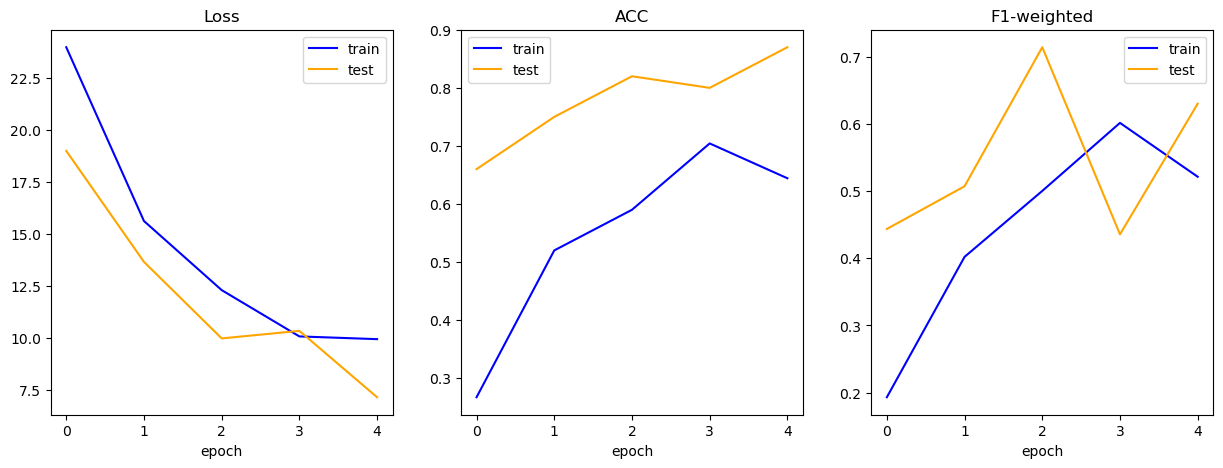

In [30]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001
weight_decay = 0.03

sampling_weights = torch.Tensor([1, 1, 1, 1, 1, 1, 1, 1 / 0.8, 1 / 0.5, 1 / 0.3])
criterion = CustomCRELossForImbalancedDataset(sampling_weights)
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# train two more apochs in comparison to previous training
N_EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")


model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_imbalanced_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_imabalnced_set_with_weighted_loss.pth')

Ideally your F1 score should be higher when adapting weighted sampling or weighted loss than when model is trained on imbalanced dataset without weighted loss or weighted sampling. Although, the dataset for this assignment is very small and training on small number of epochs can be unstable, which can lessen the effect of augmentations, weighted sampling and weighted loss

In [31]:
# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")